# Feed in tariffs installation register for small renewables

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyproj
import re
import os

os.chdir('/Users/simon/Desktop/uk-map/')
%matplotlib inline

In [3]:
# read in the FiTs data in three parts

# converted from xlsx using command line xlsx2csv
# reason is that read_csv is way faster than read_xlsx
# these are really large files

# instructions at the link:
# https://linoxide.com/linux-how-to/methods-convert-xlsx-format-files-csv-linux-cli/

# here's the command I used:
# xlsx2csv fit_installation_report_31_dec_2018_part2.xlsx > fit_part2.csv

# if it throws an error then open the file in Excel and save as CSV

df = pd.read_csv('fit_part1.csv')
df2 = pd.read_csv('fit_part2.csv')
df3 = pd.read_csv('fit_part3.csv')

#df = pd.read_excel('fit_installation_report_31_dec_2018_part1.xlsx')
#df2 = pd.read_excel('fit_installation_report_31_dec_2018_part2.xlsx')
#df3 = pd.read_excel('fit_installation_report_31_dec_2018_part3.xlsx')
# df.convert_objects(convert_dates='coerce', convert_numeric=True)

# name columns based on 4th rows

df.columns = df.iloc[4]
df2.columns = df2.iloc[3]
df3.columns = df3.iloc[3]

# drop the empty rows at the top

df.drop(df.index[:5], inplace=True)
df2.drop(df2.index[:4], inplace=True)
df3.drop(df3.index[:4], inplace=True)


# convert commissioning date to datetime
# this step is v slow

df['Commissioning date'] = pd.to_datetime(df['Commissioning date'], dayfirst=True)
df2['Commissioning date'] = pd.to_datetime(df2['Commissioning date'], dayfirst=True)
df3['Commissioning date'] = pd.to_datetime(df3['Commissioning date'], dayfirst=True)

# convert capacity to float
# this step is v slow

df['Installed capacity'] = df['Installed capacity'].astype(float)
df2['Installed capacity'] = df2['Installed capacity'].astype(float)
df3['Installed capacity'] = df3['Installed capacity'].astype(float)

#combine the datasets

fits = df.append(df2, ignore_index=True)
fits = fits.append(df3, ignore_index=True)


/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (3,4,7,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# find commissioning year

fits['Year Open'] = fits['Commissioning date'].dt.year

In [5]:
# use a dict to translate tech types


di = {
    'Photovoltaic': 'Solar',
    'Wind': 'Wind',
    'Hydro': 'Hydro',
    'Micro CHP': 'Gas',
    'Anaerobic digestion': 'Waste',
}

di2 = {
    
    'Wind': 'Onshore Wind',
    'Hydro': 'Small Hydro',
    'Micro CHP': 'Micro CHP',
    'Anaerobic digestion': 'Anaerobic Digestion',
}

fits['Fuel'] = fits['Technology'].map(di)
fits['Type'] = fits['Technology'].map(di2)

In [6]:
# turn capacities into MW not kW

fits['Installed capacity'] = fits['Installed capacity']/1000.

In [7]:
# select the columns we want

fits = fits[[
    'Installation Postcode', 'Fuel','Type', 'Installed capacity',
    'Year Open', 'Installation type', 'Country','Government office region',
    'Local authority'
]]

fits.columns = ['Installation Postcode','Fuel','Type','Capacity (MW)','Year Open','Installation type','Country','Region','Local authority']

In [8]:
print str(fits['Capacity (MW)'][fits['Capacity (MW)']>=1].sum())
print str(fits['Capacity (MW)'][fits['Capacity (MW)']<1].sum())

1540.40713
4600.66845999


In [9]:
# exclude sites ≥ 1MW, which we assume are in the REPD
# (I've checked a couple and they did appear)

fits = fits[fits['Capacity (MW)']<1]

In [10]:
# show a summary of the data

fits.pivot_table(index={'Fuel'},values='Capacity (MW)',aggfunc={'sum','count'}).reset_index()

,Fuel,count,sum
0,Gas,509,0.53787
1,Hydro,1092,134.73521
2,Solar,827830,3782.14703
3,Waste,331,131.43218
4,Wind,7430,551.81617


In [11]:
# take first 3 characters of each postcode

fits['short_post'] = fits['Installation Postcode'].str[0:3]

In [12]:
# import data on the lat/long of each UK postcode

post_codes = pd.read_csv('ukpostcodes.csv')

# drop lines that have lat 99.999 and long 0.000

post_codes = post_codes[post_codes.latitude!=99.999999]


# take the first 3 characters of each code

post_codes['short_post'] = post_codes['postcode'].str[0:3]


# find the average lat/long for each 3-character

avg_code = post_codes[['short_post', 'latitude', 'longitude']].groupby(['short_post']).mean().reset_index()

avg_code.columns = ['short_post','Latitude','Longitude']

In [13]:
#merge the datasets
fits = pd.merge(fits,avg_code,left_on=['short_post'],right_on=['short_post'], how='left')

In [14]:
# some of the sites don't show a match in the postcode database
# this includes a chunk that is marked "unknown" postcode
# once we aggregate to local authority area, we will just use the average location for sites in the that area

print str(fits['Capacity (MW)'][fits['Latitude'].isnull()].sum()) + ' MW with no lat/long'
print str(fits['Capacity (MW)'][fits['Latitude'].notnull()].sum()) + ' MW that has lat/long'

1015.68105 MW with no lat/long
3584.98741 MW that has lat/long


In [15]:
# data summary again to check nothing lost

fits.pivot_table(index={'Fuel'},values='Capacity (MW)',aggfunc={'sum','count'}).reset_index()

,Fuel,count,sum
0,Gas,509,0.53787
1,Hydro,1092,134.73521
2,Solar,827830,3782.14703
3,Waste,331,131.43218
4,Wind,7430,551.81617


In [16]:
# create timeseries

fits_yr = pd.DataFrame()

for year in range(2004, 2019):
    operating = fits[[
        'Local authority', 'Capacity (MW)', 'Fuel', 'Latitude',
        'Longitude','Region','Type'
    ]].loc[(fits['Year Open'] <= year)].groupby(
               ['Local authority', 'Fuel']).agg({
                   'Capacity (MW)': 'sum',
                   'Latitude': 'mean',
                   'Longitude': 'mean',
        'Region': 'first',
        'Type': 'first'
               }).reset_index()
    #    operating['Year'] = year
    #    operating['Age'] = operating['Year'] - operating['Start Year']
    #    operating['Start Year'] = operating['Start Year'].astype('int' , inplace=True)

    #operating_plants['Year'] = year
    operating['Year'] = year
    #byplant = byplant.append(operating_plants)
    fits_yr = fits_yr.append(operating)

In [17]:
# another data summary check

fits_yr[fits_yr.Year==2018].pivot_table(index={'Fuel'},values='Capacity (MW)',aggfunc={'sum','count'}).reset_index()

,Fuel,count,sum
0,Gas,225,0.53787
1,Hydro,134,134.55821
2,Solar,387,3782.14703
3,Waste,121,131.43218
4,Wind,285,551.81617


In [18]:
# check on amount of older capacity that might retire by 2030
# it's basically negligible so we will ignore it!

fits_yr[fits_yr.Year==2004].pivot_table(index={'Fuel'},values='Capacity (MW)',aggfunc={'sum','count'}).reset_index()

,Fuel,count,sum
0,Hydro,25,0.50970
1,Solar,152,1.02277
2,Wind,34,0.31060


In [19]:
#fits_yr.sort_values(by='Year',ascending=False)

In [20]:
fits_yr['yearStart'] = fits_yr.Year
fits_yr['yearEnd'] = np.where(fits_yr.Year<2018,fits_yr.Year,2019)

In [21]:
# print info on authorities with less than 1MW

print str(fits_yr['Capacity (MW)'][(fits_yr['Capacity (MW)']<1)&(fits_yr.Year==2018)].sum())
print str(fits_yr['Capacity (MW)'][(fits_yr['Capacity (MW)']>=1)&(fits_yr.Year==2018)].sum())

# drop entries below 1MW

tiny_fits = fits_yr[(fits_yr['Capacity (MW)']<1)]
fits_map = fits_yr[fits_yr['Capacity (MW)']>=1]

100.64795
4499.84351


In [22]:
# show first entries of local authories with less than 1MW

tiny_fits.head()

,Local authority,Fuel,Capacity (MW),Latitude,Region,Type,Longitude,Year,yearStart,yearEnd
0,Aberdeenshire,Solar,0.00224,57.089737,Scotland,NaN,-2.595242,2004,2004,2004
1,Allerdale,Hydro,0.00400,54.807704,North West,Small Hydro,-3.239076,2004,2004,2004
2,Angus,Hydro,0.02000,56.528526,Scotland,Small Hydro,-3.482225,2004,2004,2004
3,Angus,Solar,0.00990,56.626257,Scotland,NaN,-2.785449,2004,2004,2004
4,Argyll & Bute,Hydro,0.03430,56.007365,Scotland,Small Hydro,-4.987014,2004,2004,2004


In [23]:
fits_map.rename(columns={'Local authority':'Site'},inplace=True)

fits_map.sort_values(by='Capacity (MW)',ascending=False).head()

/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


,Site,Fuel,Capacity (MW),Latitude,Region,Type,Longitude,Year,yearStart,yearEnd
230,Cornwall,Solar,96.43249,50.350731,South West,NaN,-4.800556,2018,2018,2019
230,Cornwall,Solar,94.67446,50.350894,South West,NaN,-4.799615,2017,2017,2017
229,Cornwall,Solar,92.14101,50.350893,South West,NaN,-4.799197,2016,2016,2016
223,Cornwall,Solar,86.73672,50.351373,South West,NaN,-4.796596,2015,2015,2015
7,Aberdeenshire,Wind,81.95970,57.407223,Scotland,Onshore Wind,-2.400671,2018,2018,2019


In [24]:
# save the data for the map

fits_map.to_csv('fits.csv',index=False,encoding='utf-8')

# analysis and checks

In [74]:
fits[(fits['Local authority']=='Southwark')&(fits.Latitude.notnull())].sort_values(['Latitude'])

,Installation Postcode,Fuel,Type,Capacity (MW),Year Open,Installation type,Country,Region,Local authority,short_post,Latitude,Longitude
694277,SE22,Gas,Micro CHP,0.00100,2011,Domestic,England,London,Southwark,SE2,51.442221,-0.037901
365045,SE22,Solar,NaN,0.00200,2014,Domestic,England,London,Southwark,SE2,51.442221,-0.037901
174819,SE24,Solar,NaN,0.00400,2015,Domestic,England,London,Southwark,SE2,51.442221,-0.037901
64709,SE24,Solar,NaN,0.00375,2016,Domestic,England,London,Southwark,SE2,51.442221,-0.037901
63214,SE22,Solar,NaN,0.00399,2016,Domestic,England,London,Southwark,SE2,51.442221,-0.037901
755702,SE22,Solar,NaN,0.00150,2011,Domestic,England,London,Southwark,SE2,51.442221,-0.037901
668503,SE22,Solar,NaN,0.00225,2011,Domestic,England,London,Southwark,SE2,51.442221,-0.037901
767623,SE22,Solar,NaN,0.00164,2011,Domestic,England,London,Southwark,SE2,51.442221,-0.037901
252504,SE22,Solar,NaN,0.00300,2014,Domestic,England,London,Southwark,SE2,51.442221,-0.037901
687767,SE21,Solar,NaN,0.00400,2011,Domestic,England,London,Southwark,SE2,51.442221,-0.037901


In [46]:
post_codes[post_codes['latitude']>99.9].sort_values('latitude',ascending=False)

,id,postcode,latitude,longitude,short_post


In [75]:
avg_code[avg_code['short_post'].str.contains('SE1')]

,short_post,Latitude,Longitude
1042,SE1,51.480504,-0.044447


In [25]:
for year in range(2008, 2020):
    print str(year) + ': ' + str(fits['Capacity (MW)'][(fits['Year Open'] <= year)].count()) + ' sites ('+ str(
            fits['Capacity (MW)'][(fits['Year Open'] <= year) &
                                (fits['Capacity (MW)'] >= 0.01)].count()) + ' ≥10kW; '+ str(
            fits['Capacity (MW)'][(fits['Year Open'] <= year) &
                                (fits['Capacity (MW)'] < 0.005)].count()) + ' <5kW) – mean ' + str(round(
            fits['Capacity (MW)'][(fits['Year Open'] <= year)].mean()*1000)) + 'kW '

2008: 3150 sites (188 ≥10kW; 2275 <5kW) – mean 4.0kW 
2009: 5216 sites (321 ≥10kW; 3976 <5kW) – mean 5.0kW 
2010: 27372 sites (744 ≥10kW; 25229 <5kW) – mean 4.0kW 
2011: 224106 sites (4518 ≥10kW; 214557 <5kW) – mean 4.0kW 
2012: 382540 sites (10863 ≥10kW; 363482 <5kW) – mean 4.0kW 
2013: 476656 sites (15204 ≥10kW; 451716 <5kW) – mean 4.0kW 
2014: 600874 sites (20987 ≥10kW; 568302 <5kW) – mean 5.0kW 
2015: 764550 sites (29508 ≥10kW; 720691 <5kW) – mean 5.0kW 
2016: 801871 sites (32319 ≥10kW; 754055 <5kW) – mean 5.0kW 
2017: 822292 sites (33547 ≥10kW; 772178 <5kW) – mean 6.0kW 
2018: 837186 sites (34237 ≥10kW; 785123 <5kW) – mean 5.0kW 
2019: 837186 sites (34237 ≥10kW; 785123 <5kW) – mean 5.0kW 


In [18]:
fits_yr[(fits_yr.Year==2018)].sort_values(by='Installed capacity',ascending=False)

,Local authority,Fuel,latitude,Government office region,Installed capacity,longitude,Year
238,Cornwall,Solar,50.350780,South West,194.11655,-4.800455,2018
1135,Wiltshire,Solar,51.320778,South West,109.91570,-2.012284,2018
7,Aberdeenshire,Wind,57.407445,Scotland,107.17970,-2.401488,2018
476,Highland,Hydro,57.225056,Scotland,80.68545,-4.653127,2018
851,Shropshire,Solar,52.672546,West Midlands,73.41233,-2.771581,2018
240,Cornwall,Wind,50.393821,South West,64.16480,-4.731582,2018
909,South Somerset,Solar,51.053644,South West,52.43932,-2.767825,2018
827,Sedgemoor,Solar,51.200607,South West,48.34463,-2.956561,2018
344,East Riding of Yorkshire,Solar,53.856204,Yorkshire and The Humber,45.75984,-0.581254,2018
466,Herefordshire County of,Solar,52.077121,West Midlands,43.65214,-2.692056,2018


In [23]:
fits_yr[(fits_yr['Local authority']=='Cornwall')&(fits_yr['Fuel']=='Solar')].sort_values(by='Year',ascending=False)

,Local authority,Fuel,latitude,Installed capacity,longitude,Year
216,Cornwall,Solar,50.350780,92.66453,-4.800455,2018
216,Cornwall,Solar,50.350944,90.96461,-4.799511,2017
216,Cornwall,Solar,50.350944,88.63162,-4.799090,2016
214,Cornwall,Solar,50.351426,85.17267,-4.796486,2015
207,Cornwall,Solar,50.351841,68.55742,-4.793472,2014
199,Cornwall,Solar,50.353385,50.29557,-4.788550,2013
195,Cornwall,Solar,50.352858,41.51807,-4.790693,2012
184,Cornwall,Solar,50.350247,21.88164,-4.800872,2011
151,Cornwall,Solar,50.358437,1.78559,-4.783392,2010


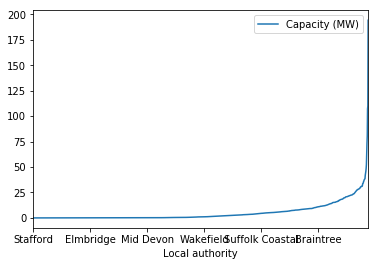

In [65]:
chart = fits_yr[['Local authority','Capacity (MW)']][fits_yr.Year==2018]
chart = chart.sort_values(by='Capacity (MW)')
x = chart['Local authority']
plt.figure(); chart.plot(x)

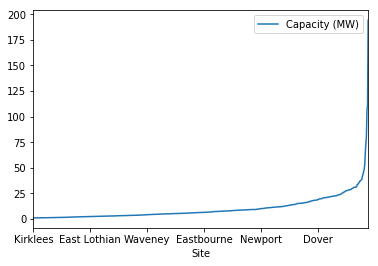

In [68]:
chart = fits_map[['Site','Capacity (MW)']][fits_map.Year==2018]
chart = chart.sort_values(by='Capacity (MW)')
x = chart['Site']
plt.figure(); chart.plot(x)

In [20]:
# group fits data by local authority and tech type

agg = fits[['Local authority','Installed capacity','Fuel','latitude','longitude']][fits['Year Open']=<2018].groupby(['Local authority','Fuel']).agg({'Installed capacity':'sum','latitude':'mean','longitude':'mean'}).reset_index()
agg.sort_values(by='Installed capacity',ascending=False)

,Local authority,Fuel,latitude,Installed capacity,longitude
216,Cornwall,Solar,50.350780,92.66453,-4.800455
1024,Wiltshire,Solar,51.320778,52.46812,-2.012284
7,Aberdeenshire,Wind,57.407445,39.45950,-2.401488
767,Shropshire,Solar,52.672546,37.86833,-2.771581
317,East Riding of Yorkshire,Solar,53.856204,36.11452,-0.581254
225,County Durham,Solar,54.732712,32.10559,-1.615180
430,Herefordshire County of,Solar,52.077121,31.47320,-2.692056
663,Peterborough,Solar,52.662068,29.51784,-0.039964
497,Leeds,Solar,53.816986,27.59473,-1.555110
636,Northumberland,Solar,55.138124,26.81908,-1.732365


In [2]:
fits.head()

NameError: name 'fits' is not defined

In [60]:
fits['Installed capacity'][fits['Local authority']=='Unknown'].sum()

32.10413000000001

,Fuel,count,sum
0,Gas,509,0.53787
1,Hydro,1146,220.95331
2,Solar,828146,4904.30306
3,Waste,416,289.83518
4,Wind,7505,725.44617


In [26]:
# find sites without a postcode
na_free = fits['Installation Postcode'].dropna()
no_postcode = fits[~fits['Installation Postcode'].index.isin(na_free.index)]

# capacity without a postcode
no_postcode_mw = no_postcode['Installed capacity'].sum()
no_postcode_mw = '{0:,.0f}'.format(no_postcode_mw)
total_mw = fits['Installed capacity'].sum()
total_mw = '{0:,.0f}'.format(total_mw)
#no_postcode_share = no_postcode_mw/total_mw*100.

print str(total_mw) + ' MW' + ' – total capacity with a FiT'
print str(no_postcode_mw) + ' MW' + ' – capacity without a postcode'
#print str(no_postcode_share) + ' %' + ' – share with no postcode'

6,141 MW – total capacity with a FiT
0 MW – capacity without a postcode


In [57]:
# group fits data by short postcode and tech type

agg = fits[['Local authority','Installed capacity','Fuel']].groupby(['Local authority','Fuel']).sum().reset_index()
agg.sort_values(by='Installed capacity',ascending=False)

3,Local authority,Fuel,Installed capacity
238,Cornwall,Solar,194.11655
1135,Wiltshire,Solar,109.91570
7,Aberdeenshire,Wind,107.17970
476,Highland,Hydro,80.79745
851,Shropshire,Solar,73.41233
240,Cornwall,Wind,64.16480
909,South Somerset,Solar,52.43932
827,Sedgemoor,Solar,48.34463
344,East Riding of Yorkshire,Solar,45.75984
466,Herefordshire County of,Solar,43.65214


In [41]:
fits[fits['Installation Postcode'].str.contains('OX')]

3,Installation Postcode,Technology,Installed capacity,Year Open,Commissioning date,Installation type,Country,Government office region,Fuel,Type,short_post
4,OX33,Photovoltaic,0.00560,2018,2018-12-07 00:00:00,Domestic,England,South East,Solar,NaN,OX
143,OX2,Photovoltaic,0.00180,2018,2018-10-30 00:00:00,Domestic,England,South East,Solar,NaN,OX
274,OX7,Photovoltaic,0.00286,2018,2018-10-01 00:00:00,Domestic,England,South East,Solar,NaN,OX
430,OX11,Photovoltaic,0.00569,2018,2018-11-10 00:00:00,Domestic,England,South East,Solar,NaN,OX
439,OX2,Photovoltaic,0.00318,2018,2018-11-06 00:00:00,Domestic,England,South East,Solar,NaN,OX
485,OX10,Photovoltaic,0.00420,2018,2018-11-10 00:00:00,Domestic,England,South East,Solar,NaN,OX
491,OX14,Photovoltaic,0.00392,2018,2018-11-16 00:00:00,Domestic,England,South East,Solar,NaN,OX
555,OX17,Photovoltaic,0.00270,2018,2018-02-26 00:00:00,Domestic,England,South East,Solar,NaN,OX
569,OX26,Photovoltaic,0.00402,2018,2018-11-10 00:00:00,Domestic,England,South East,Solar,NaN,OX
643,OX14,Photovoltaic,0.00490,2018,2018-11-14 00:00:00,Domestic,England,South East,Solar,NaN,OX


In [23]:
fits.head()

3,Installation Postcode,Technology,Installed capacity,Year Open,Commissioning date,Installation type,Country,Government office region,Fuel,Type,short_post
0,CO3,Photovoltaic,0.00165,2018,2018-11-14,Domestic,England,East of England,Solar,NaN,CO
1,SL6,Photovoltaic,0.00420,2018,2018-09-29,Domestic,England,South East,Solar,NaN,SL
2,HR1,Photovoltaic,0.00360,2018,2018-11-16,Domestic,England,West Midlands,Solar,NaN,HR
3,S43,Photovoltaic,0.00377,2018,2018-09-24,Domestic,England,East Midlands,Solar,NaN,S4
4,OX33,Photovoltaic,0.00560,2018,2018-12-07,Domestic,England,South East,Solar,NaN,OX


In [38]:
post_codes.head()

,id,postcode,latitude,longitude,short_post
0,1,AB10 1XG,57.144165,-2.114848,AB
1,2,AB10 6RN,57.137880,-2.121487,AB
2,3,AB10 7JB,57.124274,-2.127190,AB
3,4,AB11 5QN,57.142701,-2.093295,AB
4,5,AB11 6UL,57.137547,-2.112233,AB


In [40]:




print post_codes.head()

  short_post   latitude  longitude
0         AB  57.289753  -2.319810
1         AL  51.776408  -0.286063
2         B1  52.460068  -1.901603
3         B2  52.480576  -1.868954
4         B3  52.454778  -1.874764


In [129]:
#combine the datasets
combined = df.append(df2, ignore_index=True)

print len(combined)

print combined.describe()

814662
3      Extension(Y/N) Post Code Technology Type  Installed Capacity (kW)  \
count          814662    798756          814662                 814662.0   
unique              2      3034               5                   4748.0   
top                 N       PE1    Photovoltaic                      4.0   
freq           804431      2270          805178                 148298.0   

3       Declared Net Capacity (kW)     Application Date    Commissioned Date  \
count                     814662.0               814662               814662   
unique                      4638.0                 2820                 4132   
top                            4.0  2012-03-02 00:00:00  2011-12-05 00:00:00   
freq                      101301.0                11396                 6252   

3            MCS Issue Date Export Status Type  Tariff Code  \
count                 39659             814662       814662   
unique                38462                  5          664   
top     2017-01-04 16:

In [130]:
# find the largest site

print combined.loc[combined['Installed Capacity (kW)'] == combined['Installed Capacity (kW)'].max(),['Technology Type','Installed Capacity (kW)', 'Post Code', 'Commissioned Date']]

# find sites of 1MW of larger

print combined.loc[combined['Installed Capacity (kW)'] >= 1000,['Technology Type','Installed Capacity (kW)', 'Post Code', 'Commissioned Date']]

3           Technology Type Installed Capacity (kW) Post Code  \
32720   Anaerobic digestion                    5000       NaN   
40392                  Wind                    5000       NaN   
214147                 Wind                    5000       NaN   
342604                 Wind                    5000       NaN   

3         Commissioned Date  
32720   2016-07-26 00:00:00  
40392   2014-05-01 00:00:00  
214147  2013-03-12 00:00:00  
342604  2013-12-12 00:00:00  
3           Technology Type Installed Capacity (kW) Post Code  \
1387                  Hydro                    2000       NaN   
1604           Photovoltaic                 4460.32       NaN   
1761                  Hydro                    2000       NaN   
1773                  Hydro                    1990       NaN   
1791                  Hydro                    1500       NaN   
2605                  Hydro                    1500       NaN   
3313                  Hydro                    2000       NaN   
3852

In [131]:
# find a specific site with size >=4800kW and postcode SA13

print combined.loc[(combined['Installed Capacity (kW)'] >= 4800) & (combined['Post Code'] == 'SA13'),['Technology Type','Installed Capacity (kW)', 'Post Code', 'Commissioned Date']]

# find site with size >=4800kW

print combined.loc[(combined['Installed Capacity (kW)'] >= 4800) ,['Technology Type','Installed Capacity (kW)', 'Post Code', 'Commissioned Date']]

3    Technology Type Installed Capacity (kW) Post Code    Commissioned Date
6383    Photovoltaic                    4896      SA13  2016-06-24 00:00:00
3      Technology Type Installed Capacity (kW) Post Code    Commissioned Date
6383      Photovoltaic                    4896      SA13  2016-06-24 00:00:00
6934      Photovoltaic                    4896       NaN  2016-06-28 00:00:00
9510      Photovoltaic                  4849.5       NaN  2015-10-06 00:00:00
11300     Photovoltaic                 4930.64      BS24  2016-06-09 00:00:00
13994     Photovoltaic                  4989.6       NaN  2016-06-13 00:00:00
14134     Photovoltaic                 4998.76       NaN  2016-03-31 00:00:00
14555     Photovoltaic                 4993.92       NaN  2016-06-15 00:00:00
15547     Photovoltaic                 4996.98       NaN  2015-12-28 00:00:00
17248     Photovoltaic                 4951.44       NaN  2015-12-20 00:00:00
17467     Photovoltaic                  4955.5       NaN  2016-06-18

6,141 MW – total capacity with a FiT
0 MW – capacity without a postcode


In [153]:


print 'Capacity (MW) and number of sites without a postcode'
print no_postcode['Installed Capacity (kW)'].sum()/1000.
print no_postcode['Installed Capacity (kW)'].count()
print ''

# find no-postcode sites of 1MW of larger

large_no_postcode = no_postcode.loc[no_postcode['Installed Capacity (kW)'] >= 1000,['Technology Type','Installed Capacity (kW)', 'Post Code', 'Commissioned Date']]
large_no_postcode['Installed Capacity (MW)'] = large_no_postcode['Installed Capacity (kW)']/1000.
print ''
print 'Sites of 1MW or above without a postcode'
large_no_postcode_mw = large_no_postcode['Installed Capacity (kW)'].sum()
large_no_postcode_mw = '{0:,.0f}'.format(large_no_postcode_mw)
print large_no_postcode_mw
print large_no_postcode['Installed Capacity (MW)'].count()
print ''
print large_no_postcode[['Technology Type','Installed Capacity (MW)']].groupby(['Technology Type']).sum().reset_index()

# find no-postcode sites below 1MW

small_no_postcode = no_postcode.loc[no_postcode['Installed Capacity (kW)'] < 1000,['Technology Type','Installed Capacity (kW)', 'Post Code', 'Commissioned Date']]
small_no_postcode['Installed Capacity (MW)'] = small_no_postcode['Installed Capacity (kW)']/1000.
print ''
print 'Sites below 1MW without a postcode'
small_no_postcode_mw = small_no_postcode['Installed Capacity (kW)'].sum()
small_no_postcode_mw = '{0:,.0f}'.format(small_no_postcode_mw)
print small_no_postcode_mw
print ''
print small_no_postcode[['Technology Type','Installed Capacity (MW)']].groupby(['Technology Type']).sum().reset_index()

print''
print small_no_postcode[['Technology Type','Installed Capacity (MW)']].groupby(['Technology Type']).sum().reset_index()
print 'Average kW of the small sites'
print small_no_postcode['Installed Capacity (MW)'].mean()*1000.
print 'Number of small no-postcode sites'
print small_no_postcode['Installed Capacity (MW)'].count()
print ''
print 'Average kW of the large sites'
print large_no_postcode['Installed Capacity (MW)'].mean()*1000.
print 'Number of large no-postcode sites'
print large_no_postcode['Installed Capacity (MW)'].count()
print''
print large_no_postcode[['Technology Type','Installed Capacity (MW)']].groupby(['Technology Type']).count().reset_index()

print''

print small_no_postcode_mw + large_no_postcode_mw

Capacity (MW) and number of sites without a postcode
2226.086823
15906


Sites of 1MW or above without a postcode
1,290,870
424

3      Technology Type  Installed Capacity (MW)
0  Anaerobic digestion               109.204000
1                Hydro                74.353000
2         Photovoltaic               986.883425
3                 Wind               120.430000

Sites below 1MW without a postcode
935,216

3      Technology Type  Installed Capacity (MW)
0  Anaerobic digestion                73.150000
1                Hydro               102.039720
2            Micro CHP                 0.008980
3         Photovoltaic               459.615248
4                 Wind               300.402450

3      Technology Type  Installed Capacity (MW)
0  Anaerobic digestion                73.150000
1                Hydro               102.039720
2            Micro CHP                 0.008980
3         Photovoltaic               459.615248
4                 Wind               300.402450
Average k

In [64]:
# create short post code of 2 characters
combined['short_post'] = combined['Post Code'].str[0:2]

print combined.loc[(combined['Installed Capacity (kW)'] >= 4800) ,['Technology Type','Installed Capacity (kW)', 'Post Code', 'short_post']]

3      Technology Type Installed Capacity (kW) Post Code short_post
6383      Photovoltaic                    4896      SA13         SA
6934      Photovoltaic                    4896       NaN        NaN
9510      Photovoltaic                  4849.5       NaN        NaN
11300     Photovoltaic                 4930.64      BS24         BS
13994     Photovoltaic                  4989.6       NaN        NaN
14134     Photovoltaic                 4998.76       NaN        NaN
14555     Photovoltaic                 4993.92       NaN        NaN
15547     Photovoltaic                 4996.98       NaN        NaN
17248     Photovoltaic                 4951.44       NaN        NaN
17467     Photovoltaic                  4955.5       NaN        NaN
17765     Photovoltaic                  4998.6       NaN        NaN
17769     Photovoltaic                 4998.02       NaN        NaN
17770     Photovoltaic                    4992       NaN        NaN
17771     Photovoltaic                 4998.02  

In [32]:

# group by short postcode and tech type

postcode_mw = combined[['short_post','Installed Capacity (kW)','Technology Type']].groupby(['short_post','Technology Type']).sum().reset_index()
postcode_mw['Installed Capacity (kW)'].describe()

count       674.000000
mean       5539.069831
std       13346.343574
min           0.610000
25%           6.782500
50%         109.850000
75%        3102.125000
max      103503.102000
Name: Installed Capacity (kW), dtype: float64

In [41]:
#merge the datasets
postcode_mw = pd.merge(postcode_mw,post_codes,left_on=['short_post'],right_on=['short_post'], how='inner')


In [49]:
# create MW capacity column
postcode_mw['Installed Capacity (MW)'] = postcode_mw['Installed Capacity (kW)']/1000.
# could also chuck out data where the capacity is below a certain level, using .loc
# output to csv
postcode_mw.to_csv('FITs_data.csv')

In [47]:
# find the largest capacity point
print postcode_mw.loc[postcode_mw['Installed Capacity (kW)'] == postcode_mw['Installed Capacity (kW)'].max(),['latitude', 'longitude','short_post']]


      latitude  longitude short_post
159  50.831227  -3.675772         EX


In [21]:
print df['X-coordinate'].loc[[1301,1302]]
print df.loc[1301]

1301    333726
1302       NaN
Name: X-coordinate, dtype: object
4
NaN                                                                   NaN
NaN                                                                   NaN
Old Ref ID                                                          B0318
Ref ID                                                               1612
Record Last Updated (dd/mm/yyyy)                      2012-10-25 00:00:00
Operator (or Applicant)                                   Wrexham Council
Site Name                                       Wrexham Social Housing PV
Technology Type                                       Solar Photovoltaics
Installed Capacity (MWelec)                                           5.4
CHP Enabled                                                           n/a
RO Banding (ROC/MWh)                                                  NaN
FiT Tariff (p/kWh)                                                    NaN
CfD Capacity (MW)                             

In [22]:
df['X-coordinate'] = df['X-coordinate'].fillna(-477441)
df['Y-coordinate'] = df['Y-coordinate'].fillna(481803)
print df[['X-coordinate','Y-coordinate']].loc[[1301,1302]]

4     X-coordinate  Y-coordinate
1301      333726.0      349750.0
1302     -477441.0      481803.0


In [23]:
#df[['Y-coordinate']].isnull()*53.492548

In [24]:
def proj_transform(df):
    bng = pyproj.Proj(init='epsg:27700')
    wgs84 = pyproj.Proj(init='epsg:4326')
    lon,lat = pyproj.transform(bng,wgs84, df['X-coordinate'], df['Y-coordinate'])    
    df['lat'] = lat
    df['lon'] = lon
    return df

df = df.apply(proj_transform, axis=1)
print df[['X-coordinate', 'Y-coordinate','lat','lon']]

4     X-coordinate  Y-coordinate        lat       lon
5         302219.0      166320.0  51.387471 -3.406610
6         218740.0      652937.0  55.735807 -4.888574
7         447490.0      424684.0  53.716417 -1.281885
8         585300.0      286900.0  52.448628  0.725273
9         476500.0      259700.0  52.230195 -0.881341
10        337200.0      559800.0  54.928912 -2.981518
11        411500.0      192500.0  51.631197 -1.835249
12        302400.0      256000.0  52.193569 -3.429272
13        314900.0      121800.0  50.989286 -3.213854
14        457200.0      424000.0  53.709298 -1.134897
15        583577.0      125972.0  51.003844  0.615143
16        229288.0      801062.0  57.068853 -4.817386
17        428049.0      530414.0  54.668027 -1.566632
18        361823.0      131905.0  51.085183 -2.546429
19        219921.0      600195.0  55.262926 -4.835545
20        422804.0       94625.0  50.750782 -1.678119
21        117392.0      488885.0  54.217507 -6.336669
22        545350.0      1819

In [25]:
summary = df.groupby(['Technology Type','Development Status']).sum().reset_index()
summary[['Technology Type','Development Status', 'Installed Capacity (MWelec)']].to_csv('summary.csv')
print summary[['Technology Type','Development Status', 'Installed Capacity (MWelec)']].tail(10)

4   Technology Type               Development Status  \
118    Wind Onshore                   Decommissioned   
119    Wind Onshore                      Operational   
120    Wind Onshore   Planning Application Submitted   
121    Wind Onshore   Planning Application Withdrawn   
122    Wind Onshore      Planning Permission Expired   
123    Wind Onshore      Planning Permission Granted   
124    Wind Onshore      Planning Permission Refused   
125    Wind Onshore  Secretary of State - Intervened   
126    Wind Onshore     Secretary of State - Refusal   
127    Wind Onshore               Under Construction   

4    Installed Capacity (MWelec)  
118                      38.0500  
119                   12151.4920  
120                    2180.3500  
121                    6269.4018  
122                      73.4000  
123                    2467.5500  
124                    6266.0114  
125                      40.0400  
126                     189.4000  
127                    1217.7500 

In [26]:
pivot = df.pivot_table(index='Development Status', columns='Technology Type', values='Installed Capacity (MWelec)', aggfunc='sum')
print pivot

Technology Type                  Advanced Conversion Technologies  \
Development Status                                                  
Abandoned                                                  294.62   
Appeal Granted                                              11.00   
Appeal Lodged                                               12.00   
Appeal Refused                                              16.00   
Appeal Withdrawn                                            31.00   
Decommissioned                                               9.20   
No Application Required                                       NaN   
Operational                                                 70.30   
Planning Application Submitted                              81.00   
Planning Application Withdrawn                             242.80   
Planning Permission Expired                                  9.00   
Planning Permission Granted                                645.99   
Planning Permission Refused       

In [30]:
df['Year opened'] = df['Operational'].dt.year
print df.head(10)


4   NaN  NaN Old Ref ID  Ref ID Record Last Updated (dd/mm/yyyy)  \
5   NaN  NaN    N00053B       1                       2009-07-07   
6   NaN  NaN      AA110       2                       2017-11-20   
7   NaN  NaN      B0730       3                       2017-07-03   
8   NaN  NaN    1106000       4                       2003-12-18   
9   NaN  NaN    2047000       5                       2005-09-29   
10  NaN  NaN   70700000       6                       2004-08-13   
11  NaN  NaN    9162000       7                       2004-11-29   
12  NaN  NaN  100640000       8                       2003-12-23   
13  NaN  NaN   11065000       9                       2004-08-30   
14  NaN  NaN   12076000      10                       2012-01-04   

4                       Operator (or Applicant)  \
5                                    RWE npower   
6   Orsted (formerly Dong Energy) / Peel Energy   
7            Scottish and Southern Energy (SSE)   
8                        Energy Power Resources

In [5]:
df['total'] = df['Nuclear'] + df['Biomass'] + df['Hydro'] + df['Wind'] + df['Solar'] + df['Coal'] + df ['Gas']
df['RE'] = df['Biomass'] + df['Hydro'] + df['Wind'] + df['Solar']
df['lowc'] = df['Biomass'] + df['Hydro'] + df['Wind'] + df['Solar'] + df['Nuclear']
df['fossil'] = df['Coal'] + df ['Gas']
df['coalzerohh'] = df['Coal'] < 0.1

In [6]:
df.head(10)

,Date,Nuclear,Biomass,Imports,Hydro,Wind,Solar,Gas,Coal,Demand,year,month,day,total,RE,lowc,fossil,coalzerohh
0,2009-01-01,6973.0,0.0,1412.0,246.0,148.0,0,11900.0,17650.0,38329.0,2009,1,1,36917.0,394.0,7367.0,29550.0,False
1,2009-01-01,6968.0,0.0,1290.0,245.0,157.0,0,12031.0,17770.0,38461.0,2009,1,1,37171.0,402.0,7370.0,29801.0,False
2,2009-01-01,6970.0,0.0,799.0,246.0,147.0,0,11754.0,18070.0,37986.0,2009,1,1,37187.0,393.0,7363.0,29824.0,False
3,2009-01-01,6969.0,0.0,317.0,246.0,148.0,0,11162.0,18022.0,36864.0,2009,1,1,36547.0,394.0,7363.0,29184.0,False
4,2009-01-01,6960.0,0.0,4.0,246.0,160.0,0,10812.0,17998.0,36180.0,2009,1,1,36176.0,406.0,7366.0,28810.0,False
5,2009-01-01,6969.0,0.0,-116.0,236.0,151.0,0,10698.0,17935.0,35873.0,2009,1,1,35989.0,387.0,7356.0,28633.0,False
6,2009-01-01,6964.0,0.0,-907.0,226.0,124.0,0,10735.0,17564.0,34706.0,2009,1,1,35613.0,350.0,7314.0,28299.0,False
7,2009-01-01,6967.0,0.0,-1020.0,225.0,161.0,0,10481.0,16827.0,33641.0,2009,1,1,34661.0,386.0,7353.0,27308.0,False
8,2009-01-01,6963.0,0.0,-1114.0,225.0,154.0,0,9841.0,16453.0,32522.0,2009,1,1,33636.0,379.0,7342.0,26294.0,False
9,2009-01-01,6960.0,0.0,-1088.0,224.0,165.0,0,9556.0,16037.0,31854.0,2009,1,1,32942.0,389.0,7349.0,25593.0,False


In [7]:
df.set_index('Date', inplace=True)

In [8]:
results = df['Nuclear'].head(0)

df.sort_values(['Nuclear'], ascending=False, inplace=True)
results['Nuclear'] = df['Nuclear'].head(10)

df.sort_values(['Biomass'], ascending=False, inplace=True)
results['Biomass'] = df['Biomass'].head(10)

df.sort_values(['Hydro'], ascending=False, inplace=True)
results['Hydro'] = df['Hydro'].head(10)

df.sort_values(['Wind'], ascending=False, inplace=True)
results['Wind'] = df['Wind'].head(10)

df.sort_values(['Solar'], ascending=False, inplace=True)
results['Solar'] = df['Solar'].head(10)

df.sort_values(['Gas'], ascending=False, inplace=True)
results['Gas'] = df['Gas'].head(10)

df.sort_values(['Coal'], ascending=False, inplace=True)
results['Coal'] = df['Coal'].head(10)

results.to_csv('10_largest_vals_with_dates.csv')

In [9]:
df.describe()

,Nuclear,Biomass,Imports,Hydro,Wind,Solar,Gas,Coal,Demand,year,month,day,total,RE,lowc,fossil
count,152925.000000,152925.000000,152925.000000,152925.000000,152925.000000,152925.000000,152925.000000,152925.000000,152925.000000,152925.000000,152925.000000,152925.000000,152925.000000,152925.000000,152925.000000,152925.000000
mean,7335.656204,653.908021,1205.469247,388.239655,2566.829308,474.535132,12777.886805,10210.493116,35626.276912,2012.873742,6.387778,15.696322,34407.548241,4083.512116,11419.168320,22988.379921
std,961.759615,731.201295,1636.807815,249.512969,2056.138355,1106.769477,5203.749404,6096.520493,7758.558011,2.520646,3.411183,8.792397,7659.202836,3022.037935,3253.456165,8333.597104
min,4099.000000,0.000000,-5305.000000,0.000000,8.000000,0.000000,1556.000000,0.000000,18320.000000,2009.000000,1.000000,1.000000,18090.000000,57.000000,4703.000000,3676.000000
25%,6760.000000,0.000000,144.000000,181.000000,969.000000,0.000000,8751.000000,5139.000000,29686.000000,2011.000000,3.000000,8.000000,28522.000000,1640.000000,9052.000000,16707.000000
50%,7475.000000,474.000000,1473.000000,351.000000,1952.000000,0.000000,13072.000000,10358.000000,35864.000000,2013.000000,6.000000,16.000000,34255.000000,3299.000000,10746.000000,22498.000000
75%,8047.000000,1119.000000,2512.000000,558.000000,3680.000000,261.000000,16863.000000,14798.000000,40948.000000,2015.000000,9.000000,23.000000,39686.000000,5910.000000,13353.000000,28986.000000
max,9342.000000,2441.000000,5412.000000,1403.000000,10823.000000,8910.000000,26566.000000,26044.000000,60070.000000,2017.000000,12.000000,31.000000,58578.000000,19154.000000,27318.000000,48963.000000


In [10]:
print df['Nuclear'].max()
print df['Nuclear'].idxmax()

9342.0
2013-08-19 00:00:00


In [11]:
print df.groupby(['year','month']).mean().reset_index()

     year  month      Nuclear      Biomass      Imports       Hydro  \
0    2009      1  5794.037106     0.000000  -187.636728  545.584406   
1    2009      2  8063.098958     0.000000   -55.710565  403.909970   
2    2009      3  8522.880777     0.000000    84.449151  579.504571   
3    2009      4  8389.706796     0.000000   896.759799  388.635736   
4    2009      5  6826.467742     0.000000  1351.060484  308.965726   
5    2009      6  8004.785932     0.000000   643.291728  153.376877   
6    2009      7  7874.081592     0.000000   645.163019  167.533570   
7    2009      8  7686.621965     0.000000   188.858265  370.462405   
8    2009      9  7023.880053     0.000000  -641.437564  483.439518   
9    2009     10  6353.609825     0.000000 -1201.963658  437.858416   
10   2009     11  7277.863940     0.000000  -799.442552  608.236202   
11   2009     12  7323.837753     0.000000  -801.124074  430.944863   
12   2010      1  8015.969434     0.000000 -1361.371832  258.286050   
13   2

In [39]:
monthly = df.groupby(['year','month']).mean().reset_index()
monthly['windcoal'] = monthly['Wind'] > monthly['Coal']
monthly['solarcoal'] = monthly['Solar'] > monthly['Coal']
monthly['nuc%'] = monthly['Nuclear']/monthly['total']
monthly['bio%'] = monthly['Biomass']/monthly['total']
monthly['hyd%'] = monthly['Hydro']/monthly['total']
monthly['win%'] = monthly['Wind']/monthly['total']
monthly['sol%'] = monthly['Solar']/monthly['total']
monthly['gas%'] = monthly['Gas']/monthly['total']
monthly['coa%'] = monthly['Coal']/monthly['total']
monthly['RE%'] = monthly['RE']/monthly['total']
monthly['lowc%'] = monthly['lowc']/monthly['total']


In [40]:
monthly.to_csv('power_by_month.csv')

In [38]:
daily = df.groupby(['year','month','day']).mean().reset_index()
daily['windcoal'] = daily['Wind'] > daily['Coal']
daily['solarcoal'] = daily['Solar'] > daily['Coal']
daily['coalzeroday'] = daily['Coal'] < 0.01
daily['nuc%'] = daily['Nuclear']/daily['total']
daily['bio%'] = daily['Biomass']/daily['total']
daily['hyd%'] = daily['Hydro']/daily['total']
daily['win%'] = daily['Wind']/daily['total']
daily['sol%'] = daily['Solar']/daily['total']
daily['gas%'] = daily['Gas']/daily['total']
daily['coa%'] = daily['Coal']/daily['total']
daily['RE%'] = daily['RE']/daily['total']
daily['lowc%'] = daily['lowc']/daily['total']
daily.to_csv('power_by_day.csv')

In [28]:
dailycounts = daily.groupby(['year']).sum().reset_index()
dailycounts[['year','windcoal','solarcoal','coalzeroday']].to_csv('dailycounts.csv')

In [16]:
temp01 = df.groupby(['year','month']).sum().reset_index()
temp02 = temp01[['year','month','coalzerohh']]
temp02.to_csv('coal_free_HH.csv')

In [37]:
daily.head(10)

,year,month,day,Nuclear,Biomass,Imports,Hydro,Wind,Solar,Gas,...,Demand,total,RE,lowc,fossil,coalzerohh,windcoal,solarcoal,coalzeroday,nuc%
0,2009,1,1,6967.541667,0.0,1166.562500,309.166667,152.062500,0.0,11578.791667,...,37845.145833,36678.583333,461.229167,7428.770833,29249.812500,0.0,False,False,False,0.189962
1,2009,1,2,6398.958333,0.0,209.208333,322.270833,360.520833,0.0,14397.083333,...,40837.187500,40627.979167,682.791667,7081.750000,33546.229167,0.0,False,False,False,0.157501
2,2009,1,3,5798.312500,0.0,349.750000,356.145833,339.666667,0.0,15162.770833,...,40246.875000,39890.041667,695.812500,6494.125000,33395.916667,0.0,False,False,False,0.145357
3,2009,1,4,5468.229167,0.0,85.812500,339.270833,458.312500,0.0,16307.125000,...,40716.062500,40529.083333,797.583333,6265.812500,34263.270833,0.0,False,False,False,0.134921
4,2009,1,5,5130.208333,0.0,-636.729167,447.000000,645.312500,0.0,18964.979167,...,46577.208333,46599.458333,1092.312500,6222.520833,40376.937500,0.0,False,False,False,0.110092
5,2009,1,6,5134.083333,0.0,-1040.895833,358.833333,541.229167,0.0,19026.270833,...,48078.041667,48267.604167,900.062500,6034.145833,42233.458333,0.0,False,False,False,0.106367
6,2009,1,7,5482.416667,0.0,-458.979167,358.541667,233.000000,0.0,18628.666667,...,48130.270833,48000.958333,591.541667,6073.958333,41927.000000,0.0,False,False,False,0.114215
7,2009,1,8,5520.729167,0.0,-721.791667,337.000000,562.645833,0.0,17661.687500,...,46920.562500,47107.645833,899.645833,6420.375000,40687.270833,0.0,False,False,False,0.117194
8,2009,1,9,5230.625000,0.0,-1370.479167,389.875000,726.770833,0.0,17726.250000,...,46754.416667,47355.500000,1116.645833,6347.270833,41008.229167,0.0,False,False,False,0.110454
9,2009,1,10,5584.791667,0.0,-481.333333,431.750000,1764.833333,0.0,15408.666667,...,43283.791667,43631.166667,2196.583333,7781.375000,35849.791667,0.0,False,False,False,0.128000


In [47]:
temp01 = daily.groupby(['year']).count().reset_index()
temp02 = temp01[['year','day']]
temp02.head(10)

,year,day
0,2009,365
1,2010,365
2,2011,365
3,2012,366
4,2013,365
5,2014,365
6,2015,365
7,2016,366
8,2017,264


In [42]:
monthlycounts = monthly.groupby(['year']).sum().reset_index()
monthlycounts[['year','windcoal','solarcoal']].to_csv('monthlycounts.csv')

In [86]:
fits[fits['Capacity (MW)']>=1].sort_values(by='Capacity (MW)', ascending=False)

,Installation Postcode,Fuel,Type,Capacity (MW),Year Open,Installation type,Country,Region,Local authority
426790,Unknown,Wind,Onshore Wind,5.00000,2014,Non Domestic (Commercial),England,East Midlands,Derby
170973,Unknown,Waste,Anaerobic Digestion,5.00000,2016,Non Domestic (Industrial),England,East of England,St Edmundsbury
462539,Unknown,Wind,Onshore Wind,5.00000,2013,Non Domestic (Commercial),England,South West,Bristol City of
448255,Unknown,Wind,Onshore Wind,5.00000,2013,Non Domestic (Commercial),England,East of England,Mid Suffolk
255705,Unknown,Solar,NaN,4.99980,2015,Non Domestic (Commercial),England,South West,East Dorset
369317,Unknown,Solar,NaN,4.99980,2014,Non Domestic (Commercial),England,South West,Forest of Dean
521374,Unknown,Solar,NaN,4.99968,2012,Non Domestic (Commercial),England,South East,New Forest
773944,Unknown,Solar,NaN,4.99968,2011,Non Domestic (Commercial),England,South West,Cornwall
186081,Unknown,Solar,NaN,4.99928,2015,Non Domestic (Commercial),England,South West,Forest of Dean
194265,Unknown,Solar,NaN,4.99928,2015,Non Domestic (Commercial),England,South West,Taunton Deane


In [89]:
print str(fits['Capacity (MW)'][(fits['Capacity (MW)']>=1)&(fits.Fuel=='Wind')].sum())
print str(fits['Capacity (MW)'][(fits['Capacity (MW)']<1)&(fits.Fuel=='Wind')].sum())
print str(fits['Capacity (MW)'][(fits['Capacity (MW)']>=1)&(fits.Fuel=='Solar')].sum())
print str(fits['Capacity (MW)'][(fits['Capacity (MW)']<1)&(fits.Fuel=='Solar')].sum())

173.63
551.81617
1122.15603
3782.14702999
